In [40]:
# import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as f
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import csv
import torchvision.transforms as transforms

#set seed for consistency and reproducibility
torch.manual_seed(123)
if torch.cuda.is_available:
  torch.cuda.manual_seed_all(1234)

In [41]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Data Augmentation has been performed to increase accuracy

In [42]:
# transformation for test data - nomalizing test data
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# transformation for train data 
train_transform = transforms.Compose([
    transforms.RandomRotation(10), # Add random rotation with 10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Add color jitter
    transforms.RandomHorizontalFlip(), #apply horizontal flipping
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create CIFAR-10 train dataset with updated data augmentation
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)

# Create CIFAR-10 test dataset 
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transform, download=True)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [43]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        #in_planes = input chanel size
        #planes = output chanel size
        #convolution later 1
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        #batch norm 1
        self.bn1 = nn.BatchNorm2d(planes)
        #convolution layer 2
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        #batch norm 2
        self.bn2 = nn.BatchNorm2d(planes)

        #skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    #forward pass of res-net
    def forward(self, x):
        out = f.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = f.relu(out)
        return out


In [44]:
#to edit the number of channels
channels = [32, 64, 128, 256]

- Here the averge pool layer has been removed and the parameters for the linear layer have been adjusted accordingly
- Drop out layer has also been added for regularization

In [45]:
class ResNet(nn.Module):
    def __init__(self, channels, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = channels[0]
        dropout_probability = 0.175
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels[0])
        self.layer1 = self._make_layer(block, channels[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, channels[1], num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, channels[2], num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, channels[3], num_blocks[3], stride=2)
        self.linear = nn.Linear(channels[3]*4*4, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_probability)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes 
        return nn.Sequential(*layers)

    def forward(self, x):
        out = f.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        # comment the line below to remove dropout layer
        #out = self.dropout(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # out = f.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)

        # Apply dropout
        out = self.dropout(out)

        out = self.linear(out)
        return out

In [46]:
def ResNet18():
    return ResNet(channels, BasicBlock, [2, 2, 2, 2])

5 million = 5,000,000

In [47]:
# Create an instance of ResNet18
model = ResNet18()
model.to(device)

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters: ", num_params)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#uncomment the below line for lr scheduling
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


Number of parameters:  2836010


In [48]:
def train_model(epoch):
  # num_batches = torch.ceil(torch.tensor(len(train_dataset)/100)).item()
  model.train()
  train_acc = 0
  epoch_loss = 0
  for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      # print(train_loader, len(train_loader))
      # Forward pass
      output = model(images)
      loss = criterion(output, labels)
      # acc = calculate_accuracy(output, labels)
      _, predicted = torch.max(output.data, 1)
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # epoch_acc += acc
      train_acc += (labels == predicted).sum().item()
      epoch_loss += loss.item()
      
       

  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {train_acc / len(train_dataset)}')
  return round((train_acc / len(train_dataset))*100,2)

In [49]:
# Test the model
def model_eval(best_acc):
  model.eval()
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  # Print the accuracy
  accuracy = 100 * correct / total
  print(f'Test Accuracy: {accuracy:.2f}%')
  if accuracy>best_acc:
    # Save the model checkpoint
    torch.save(model.state_dict(), 'resnet.ckpt')
  return accuracy

In [50]:
# Training loop
num_epochs = 50
best_acc = 0
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
  train_accuracies.append(train_model(epoch))
  #if (epoch+1)%5==0:
  best_acc = max(best_acc, model_eval(best_acc))
  test_accuracies.append(best_acc)
  #scheduler.step() #uncomment while implementing lr scheduling


Epoch [1/50], Loss: 1.7458, Accuracy: 0.38576
Test Accuracy: 53.11%
Epoch [2/50], Loss: 1.2647, Accuracy: 0.55338
Test Accuracy: 64.75%
Epoch [3/50], Loss: 1.0261, Accuracy: 0.63722
Test Accuracy: 70.29%
Epoch [4/50], Loss: 0.8791, Accuracy: 0.6879
Test Accuracy: 71.06%
Epoch [5/50], Loss: 0.7819, Accuracy: 0.726
Test Accuracy: 76.84%
Epoch [6/50], Loss: 0.7073, Accuracy: 0.75402
Test Accuracy: 78.50%
Epoch [7/50], Loss: 0.6487, Accuracy: 0.77466
Test Accuracy: 79.27%
Epoch [8/50], Loss: 0.6041, Accuracy: 0.79156
Test Accuracy: 79.72%
Epoch [9/50], Loss: 0.5647, Accuracy: 0.80358
Test Accuracy: 83.02%
Epoch [10/50], Loss: 0.5312, Accuracy: 0.81522
Test Accuracy: 82.42%
Epoch [11/50], Loss: 0.5049, Accuracy: 0.825
Test Accuracy: 84.20%
Epoch [12/50], Loss: 0.4796, Accuracy: 0.83248
Test Accuracy: 84.78%
Epoch [13/50], Loss: 0.4586, Accuracy: 0.84158
Test Accuracy: 85.20%
Epoch [14/50], Loss: 0.4376, Accuracy: 0.84882
Test Accuracy: 85.74%
Epoch [15/50], Loss: 0.4183, Accuracy: 0.8547
Te

[38.58, 55.34, 63.72, 68.79, 72.6, 75.4, 77.47, 79.16, 80.36, 81.52, 82.5, 83.25, 84.16, 84.88, 85.47, 85.98, 86.64, 87.16, 87.67, 88.2, 88.41, 88.82, 89.18, 89.52, 90.06, 89.96, 90.53, 90.95, 90.99, 91.31, 91.47, 91.77, 92.02, 92.13, 92.36, 92.34, 92.57, 93.01, 92.97, 93.34, 93.3, 93.5, 93.66, 93.72, 93.86, 94.12, 94.37, 94.43, 94.53, 94.81]
[53.11, 64.75, 70.29, 71.06, 76.84, 78.5, 79.27, 79.72, 83.02, 83.02, 84.2, 84.78, 85.2, 85.74, 86.59, 86.59, 86.76, 86.76, 86.85, 86.85, 87.91, 87.91, 88.67, 88.67, 88.94, 88.94, 88.94, 89.18, 89.18, 89.18, 89.93, 89.93, 89.93, 89.93, 89.93, 89.93, 89.93, 90.35, 90.35, 90.41, 90.41, 90.41, 90.41, 90.41, 90.41, 90.41, 90.41, 90.41, 90.62, 90.62]


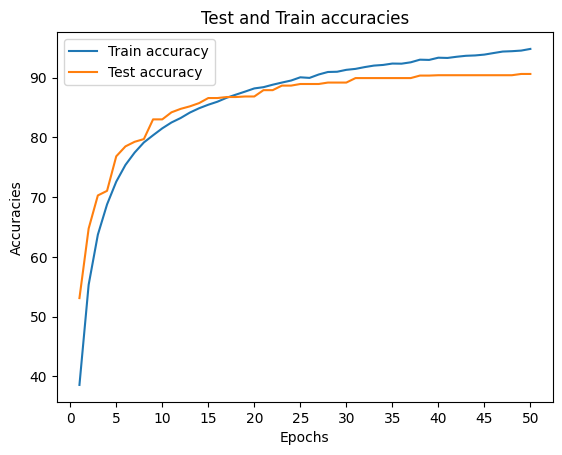

<Figure size 640x480 with 0 Axes>

In [51]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np

# Generate two arrays for comparison
x = np.arange(1, 51) # Array of x values
y1 =  train_accuracies
y2 = test_accuracies
# print(len(y1))
# print(len(y2))
print(y1)
print(y2)

# Create the line graph
plt.plot(x, y1, label='Train accuracy')
plt.plot(x, y2, label='Test accuracy')

loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
plt.gca().xaxis.set_major_locator(loc)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.title('Test and Train accuracies')

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Save the graph as a PNG image
plt.savefig('graph.png')